### Plot types of residues' spatial information
### Active vs Nonactive

##### ↓ Extract spatial information

In [1]:
from Bio.PDB import *
import urllib.request
import numpy as np
import pandas as pd
from math import sqrt
import time
import matplotlib.pyplot as plt

In [2]:
cd C:\Users\Administrator\Desktop\temp

C:\Users\Administrator\Desktop\temp


In [3]:
backbone = ["N","CA","C","O"]
aminoAcidCodes = ["ALA","ARG","ASN","ASP","CYS","GLN","GLY","GLU","HIS","ILE","LEU","LYS",
                 "MET","PHE","PRO","SER","THR","TRP","TYR","VAL"]

In [4]:
peptidasesList = pd.read_csv("Y:/Yuan/temp/MCSA_EC3.4_peptidases.csv")
peptidasesList = peptidasesList[peptidasesList.iloc[:,4] == "residue"]
peptidasesList = peptidasesList.reset_index(drop=True)
bindingSiteDic = {}
for i in range(len(peptidasesList)):
    #print(bindingSiteDic)
    if peptidasesList.loc[i,"PDB"] not in bindingSiteDic:
        bindingSiteDic[peptidasesList.loc[i,"PDB"]] = {peptidasesList.loc[i,"chain/kegg compound"]: [peptidasesList.loc[i,"resid/chebi id"]]}
    elif peptidasesList.loc[i,"chain/kegg compound"] not in bindingSiteDic[peptidasesList.loc[i,"PDB"]]:
         bindingSiteDic[peptidasesList.loc[i,"PDB"]] = {peptidasesList.loc[i,"chain/kegg compound"]: [peptidasesList.loc[i,"resid/chebi id"]]}
    else:
        bindingSiteDic[peptidasesList.loc[i,"PDB"]][peptidasesList.loc[i,"chain/kegg compound"]].append(peptidasesList.loc[i,"resid/chebi id"])
for protein in bindingSiteDic:
    for chain in bindingSiteDic[protein]:
        bindingSiteDic[protein][chain] = list(set(bindingSiteDic[protein][chain])) 

uniqueList = peptidasesList[["PDB","chain/kegg compound"]].drop_duplicates()

In [500]:
uniqueList.loc[(36,149,176,514),]

,PDB,chain/kegg compound
36,1ei5,A
149,1whs,A
176,1whs,B
514,1dki,A


In [5]:
bindingSiteDic["2bhg"]

{'A': [163.0, 84.0, 182.0, 46.0]}

In [270]:
pdbID = "1rtf"
chainOrder = "B"
PDB = PDBList()
PDB.retrieve_pdb_file(pdb_code = pdbID, pdir = "Y:/Yuan/temp", file_format="pdb")

Structure exists: 'Y:/Yuan/temp\pdb1rtf.ent' 


'Y:/Yuan/temp\\pdb1rtf.ent'

In [342]:
p = PDBParser()
structure = p.get_structure("X","Y:/Yuan/temp/pdb"+pdbID+".ent")

C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2853.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2865.
  PDBConstructionWarning)


In [346]:
oneChain = pd.DataFrame(columns = ["Seq","Residue","Center","Direction"])
if structure.header["resolution"]<=3.0:
    if chainOrder in [x.id for x in list(structure[0].get_chains())]: #Chain information not in pdb file
        for residue in structure[0][chainOrder]: 
            if residue.get_resname() in aminoAcidCodes: # Only treat common amino acid
                if residue.get_id()[2] == " ": #ignore insetions
                    if len(list(residue.get_atoms())) >3:
                        if residue.get_resname() != "GLY":  # Glysine as a special case
                            point = vectors.Vector([0,0,0])
                            for atom in residue:
                                if(atom.get_name() not in backbone):
                                    point = point + atom.get_vector()
                            center = point.__div__(len(residue)-4)
                            cToRGroup = residue["CA"].get_vector()-center
                            oneChain.loc[len(oneChain)] = [residue.get_id()[1],residue.get_resname(),center,cToRGroup]        
                        else:
                            center = residue["CA"].get_vector()
                            cToRGroup = center - (residue["C"].get_vector()+residue["N"].get_vector()+residue["O"].get_vector()).__div__(3)
                            oneChain.loc[len(oneChain)] = [residue.get_id()[1],residue.get_resname(),center,cToRGroup]


In [347]:
distanceMatrix = pd.DataFrame(columns = list(oneChain.iloc[:,0]),index = list(oneChain.iloc[:,0]))
angleMatrix = pd.DataFrame(columns = list(oneChain.iloc[:,0]),index = list(oneChain.iloc[:,0]))
numResidue = len(oneChain)
for row in range(0,numResidue):
    if row % 50 ==0:
        print(str(row)+"th row")
    for column in range(0,numResidue):
        coordinatesSubstraction = list(oneChain.loc[row,"Center"] - oneChain.loc[column,"Center"])
        distanceMatrix.iloc[row,column] = sqrt(sum(list(map(lambda x:x*x, coordinatesSubstraction))))
        v1 = oneChain.loc[row,"Direction"] 
        v2 = oneChain.loc[column,"Direction"]
        angleMatrix.iloc[row,column] = 180*np.arccos(np.dot(v1,v2)/(np.linalg.norm(v1) * np.linalg.norm(v2)))/np.pi

0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in arccos
  if sys.path[0] == '':


50th row
100th row
150th row
200th row


In [438]:
allTwoResidue = oneChain[(oneChain["Residue"] == residue1)|(oneChain["Residue"] == residue2)]
allTwoResidue.is_copy = False
allTwoResidue.loc[:,"active"] = np.where(allTwoResidue["Seq"].isin(bindingSiteDic[pdbID][chainOrder]),"yes","no")
allTwoResidue["all_point"] = None
allTwoResidue["PDBID"] = pdbID
allTwoResidue["Chain"] = chainOrder
rawAllTwoResidue=allTwoResidue.copy(deep=True)
for i,row in allTwoResidue.iterrows():
    if row["Residue"] == residue1:
        allPoint = list()
        oneResidue1 = row["Seq"]
        for oneResidue2 in rawAllTwoResidue[rawAllTwoResidue["Residue"]==residue2]["Seq"]:
            coordinate1=distanceMatrix.loc[oneResidue1,oneResidue2]
            coordinate2=angleMatrix.loc[oneResidue1,oneResidue2]      
            allPoint.append(str(coordinate1))
            allPoint.append(str(coordinate2))
        allTwoResidue.set_value(i,"all_point",",".join(allPoint))

In [ ]:
structure[0]["B"][110].get_id()[2]==" "

In [ ]:
#define two residue types for plotting
residue1 = "GLY"
residue2 = "ASP"
resultContainer = list()
for index, oneRow in uniqueList.loc[(36,149,176,514),].iterrows():
    try:
        pdbID = oneRow["PDB"]
        chainOrder = oneRow["chain/kegg compound"]
        PDB = PDBList()
        PDB.retrieve_pdb_file(pdb_code = pdbID, pdir = "Y:/Yuan/temp", file_format="pdb")
        p = PDBParser()
        structure = p.get_structure("X","Y:/Yuan/temp/pdb"+pdbID+".ent")
        oneChain = pd.DataFrame(columns = ["Seq","Residue","Center","Direction"])
        if structure.header["resolution"]<=3.0:
            if chainOrder in [x.id for x in list(structure[0].get_chains())]: #Chain information not in pdb file
                for residue in structure[0][chainOrder]: 
                    if residue.get_resname() in aminoAcidCodes: # Only treat common amino acid
                        if residue.get_id()[2] == " ": #ignore insertions
                            if len(list(residue.get_atoms())) >3:
                                if residue.get_resname() != "GLY":  # Glysine as a special case
                                    point = vectors.Vector([0,0,0])
                                    for atom in residue:
                                        if(atom.get_name() not in backbone):
                                            point = point + atom.get_vector()
                                    center = point.__div__(len(residue)-4)
                                    cToRGroup = residue["CA"].get_vector()-center
                                    oneChain.loc[len(oneChain)] = [residue.get_id()[1],residue.get_resname(),center,cToRGroup]        
                                else:
                                    center = residue["CA"].get_vector()
                                    cToRGroup = center - (residue["C"].get_vector()+residue["N"].get_vector()+residue["O"].get_vector()).__div__(3)
                                    oneChain.loc[len(oneChain)] = [residue.get_id()[1],residue.get_resname(),center,cToRGroup]
            allTwoResidue = oneChain[(oneChain["Residue"] == residue1)|(oneChain["Residue"] == residue2)]
            allTwoResidue.is_copy = False
            allTwoResidue.loc[:,"active"] = np.where(allTwoResidue["Seq"].isin(bindingSiteDic[pdbID][chainOrder]),"yes","no")
        distanceMatrix = pd.DataFrame(columns = list(oneChain.iloc[:,0]),index = list(oneChain.iloc[:,0]))
        angleMatrix = pd.DataFrame(columns = list(oneChain.iloc[:,0]),index = list(oneChain.iloc[:,0]))
        numResidue = len(oneChain)
        for row in range(0,numResidue):
            if row % 50 ==0:
                print(str(row)+"th row")
            for column in range(0,numResidue):
                coordinatesSubstraction = list(oneChain.loc[row,"Center"] - oneChain.loc[column,"Center"])
                distanceMatrix.iloc[row,column] = sqrt(sum(list(map(lambda x:x*x, coordinatesSubstraction))))
                v1 = oneChain.loc[row,"Direction"] 
                v2 = oneChain.loc[column,"Direction"]
                angleMatrix.iloc[row,column] = 180*np.arccos(np.dot(v1,v2)/(np.linalg.norm(v1) * np.linalg.norm(v2)))/np.pi
        allTwoResidue["all_point"] = None
        allTwoResidue["PDBID"] = pdbID
        allTwoResidue["Chain"] = chainOrder
        rawAllTwoResidue=allTwoResidue.copy(deep=True)
        for i,row in allTwoResidue.iterrows():
            if row["Residue"] == residue1:
                allPoint = list()
                oneResidue1 = row["Seq"]
                for oneResidue2 in rawAllTwoResidue[rawAllTwoResidue["Residue"]==residue2]["Seq"]:
                    coordinate1=distanceMatrix.loc[oneResidue1,oneResidue2]
                    coordinate2=angleMatrix.loc[oneResidue1,oneResidue2]      
                    allPoint.append(str(coordinate1))
                    allPoint.append(str(coordinate2))
                allTwoResidue.set_value(i,"all_point",",".join(allPoint))
        resultContainer.append(allTwoResidue)
    except Exception:
        print(pdbID,"skipped")
combinedResult = pd.concat(resultContainer)

In [424]:
combinedResult.to_csv("combineResult.csv")

In [432]:
coordinate1 = list()
coordinate2 = list()
flag = False
for eachRow in combinedResult[(combinedResult["Residue"] != residue2)&(combinedResult["active"]=="yes")]["all_point"]:
    if eachRow != None:
        if len(eachRow.strip().split(","))>1:
            for i,element in enumerate(eachRow.strip().split(",")):
                if i%2 == 0:
                    if float(element) <17:
                        flag = True
                        coordinate1.append(element)
                elif i%2 ==1 & flag:
                    coordinate2.append(element)
                    flag = False

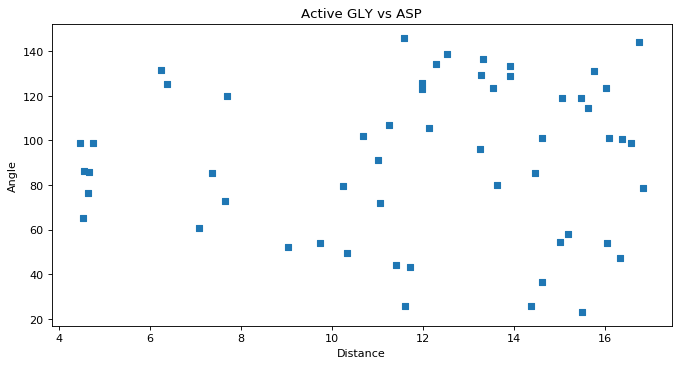

In [433]:
plt.figure(figsize = (10,5),dpi=80)

plt.scatter(coordinate1,coordinate2,
           marker = "s")


#plt.legend(["ASP_Neg","ASP_Pos","HIS_Neg","His_Pos"])

plt.xlabel("Distance")
plt.ylabel("Angle")

plt.title("Active {} vs {}".format(residue1,residue2))
plt.savefig("Active {} vs {}.png".format(residue1,residue2),dpi=300, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

plt.show()

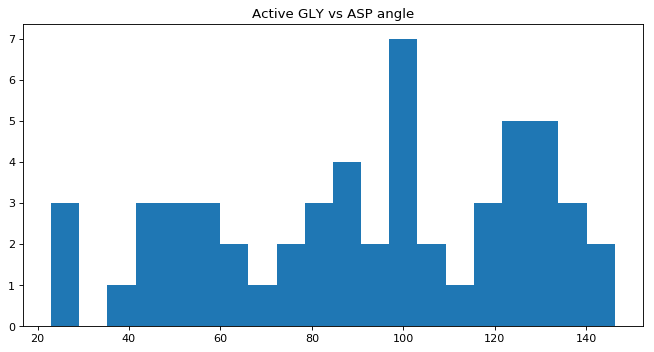

In [434]:
plt.figure(figsize = (10,5),dpi=80)
plt.hist([float(x) for x in coordinate2], bins=20)
plt.title("Active {} vs {} angle".format(residue1,residue2))
plt.savefig("Active {} vs {} angle.png".format(residue1,residue2),dpi=300, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)
plt.show()

In [435]:
coordinate1 = list()
coordinate2 = list()
flag = False
for eachRow in combinedResult[(combinedResult["Residue"] != residue2)&(combinedResult["active"]=="no")]["all_point"]:
    if eachRow != None:
        if (len(eachRow.strip().split(","))>2):
            for i,element in enumerate(eachRow.split(",")):
                if i%2 == 0:
                    if float(element) <17:
                        flag = True
                        coordinate1.append(element)
                elif i%2 ==1 & flag:
                    coordinate2.append(element)
                    flag = False

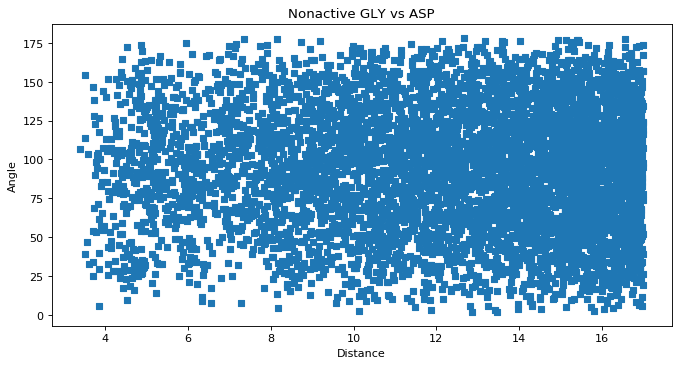

In [436]:
plt.figure(figsize = (10,5),dpi=80)

plt.scatter(coordinate1,coordinate2,
           marker = "s")


#plt.legend(["ASP_Neg","ASP_Pos","HIS_Neg","His_Pos"])

plt.xlabel("Distance")
plt.ylabel("Angle")
plt.title("Nonactive {} vs {}".format(residue1,residue2))
plt.savefig("NonActive {} vs {}.png".format(residue1,residue2),dpi=300, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

plt.show()


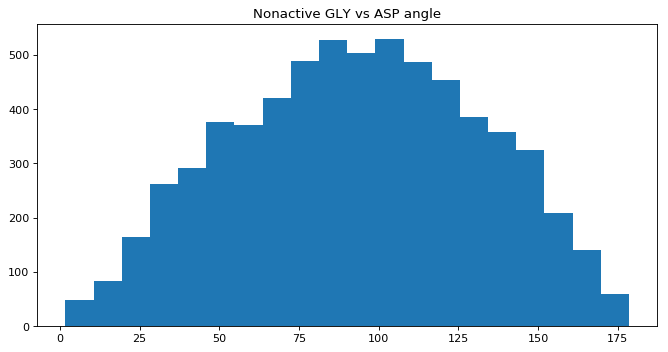

In [437]:
plt.figure(figsize = (10,5),dpi=80)
plt.hist([float(x) for x in coordinate2], bins=20)
plt.title("Nonactive {} vs {} angle".format(residue1,residue2))
plt.savefig("Nonactive {} vs {} angle.png".format(residue1,residue2),dpi=300, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)
plt.show()

## Mysql database data insertion

In [8]:
mysql_configure = pd.read_csv("Y:/Yuan/temp/mysql_connection.csv",index_col=0)

In [9]:
import pymysql
import pandas as pd
from sshtunnel import SSHTunnelForwarder
from os.path import expanduser
import getpass

sql_hostname = mysql_configure.loc["sql_hostname",]["value"]
sql_username = mysql_configure.loc["sql_username",]["value"]
sql_password = mysql_configure.loc["sql_password",]["value"]
sql_main_database = mysql_configure.loc["sql_main_database",]["value"]
sql_port = int(mysql_configure.loc["sql_port",]["value"])
ssh_host = mysql_configure.loc["ssh_host",]["value"]
ssh_user = mysql_configure.loc["ssh_user",]["value"]
ssh_password = mysql_configure.loc["ssh_password",]["value"]
ssh_port = int(mysql_configure.loc["ssh_port",]["value"])

In [451]:
##Insert pdbID
with SSHTunnelForwarder(
        (ssh_host, ssh_port),
        ssh_username=ssh_user,
        ssh_password=ssh_password,
        remote_bind_address=('127.0.0.1', sql_port)) as tunnel:
    print('SSH connected')
    
    conn = pymysql.connect(host='127.0.0.1', user=sql_username,
            passwd=sql_password, db=sql_main_database,
            port=tunnel.local_bind_port)
    for i, row in uniqueList.iterrows():
        query = '''INSERT INTO `pdbdb`.`pdbIDList` (`pdbID`, `Chain`,`type`) VALUES (%s, %s, %s);'''
        value = (row["PDB"],row["chain/kegg compound"],"Catalytic")
        conn.cursor().execute(query,value)
    conn.commit()
    print("Finished")
    conn.close()

SSH connected
Finished


In [463]:
##Insert active sites:
with SSHTunnelForwarder(
        (ssh_host, ssh_port),
        ssh_username=ssh_user,
        ssh_password=ssh_password,
        remote_bind_address=('127.0.0.1', sql_port)) as tunnel:
    print('SSH connected')
    
    conn = pymysql.connect(host='127.0.0.1', user=sql_username,
            passwd=sql_password, db=sql_main_database,
            port=tunnel.local_bind_port)  
    for protein,inProtein in bindingSiteDic.items():
        for chain,inChain in inProtein.items():
            for each in inChain:
                query = '''INSERT INTO `pdbdb`.`Site` (`pdbID`, `Chain`,`Seq`,`Active`) VALUES (%s, %s, %s,%s);'''
                value = (protein,chain,str(each),"Catalytic")
                conn.cursor().execute(query,value)
    conn.commit()
    print("Finished")
    conn.close()


SSH connected
Finished


In [11]:
pymysql.converters.encoders[np.float64] = pymysql.converters.escape_float
pymysql.converters.conversions = pymysql.converters.encoders.copy()
pymysql.converters.conversions.update(pymysql.converters.decoders)

# Insert position, distance_angle

with SSHTunnelForwarder(
        (ssh_host, ssh_port),
        ssh_username=ssh_user,
        ssh_password=ssh_password,
        remote_bind_address=('127.0.0.1', sql_port)) as tunnel:
    conn = pymysql.connect(host='127.0.0.1', user=sql_username,
                           passwd=sql_password, db=sql_main_database,
                           port=tunnel.local_bind_port)
    print('SSH connected')
    for index, oneRow in uniqueList.iterrows():
        try:
            pdbID = oneRow["PDB"]
            chainOrder = oneRow["chain/kegg compound"]
            PDB = PDBList()
            PDB.retrieve_pdb_file(pdb_code=pdbID, pdir="Y:/Lab_Public/Yuan/temp", file_format="pdb")
            p = PDBParser()
            structure = p.get_structure("X", "Y:/Lab_Public/Yuan/temp/pdb" + pdbID + ".ent")
            oneChain = pd.DataFrame(columns=["Seq", "Residue", "Center", "Direction"])
            if structure.header["resolution"] <= 3.0:
                if chainOrder in [x.id for x in list(structure[0].get_chains())]:  # Chain information not in pdb file
                    for residue in structure[0][chainOrder]:
                        if residue.get_resname() in aminoAcidCodes:  # Only treat common amino acid
                            if residue.get_id()[2] == " ":  # ignore insertions
                                if len(list(residue.get_atoms())) > 3:
                                    if residue.get_resname() != "GLY":  # Glysine as a special case
                                        point = vectors.Vector([0, 0, 0])
                                        for atom in residue:
                                            if (atom.get_name() not in backbone):
                                                point = point + atom.get_vector()
                                        center = point.__div__(len(residue) - 4)
                                        cToRGroup = residue["CA"].get_vector() - center
                                        oneChain.loc[len(oneChain)] = [residue.get_id()[1], residue.get_resname(),center, cToRGroup]
                                    else:
                                        center = residue["CA"].get_vector()
                                        cToRGroup = center - (residue["C"].get_vector() + residue["N"].get_vector() + residue["O"].get_vector()).__div__(3)
                                        oneChain.loc[len(oneChain)] = [residue.get_id()[1], residue.get_resname(),center, cToRGroup]
                                    #query = '''INSERT INTO `ResiduePosition` (`pdbID`, `chain`,`seq`,`type`,`Coordinate1`,`Coordinate2`,`Coordinate3`) VALUES (%s, %s, %s,%s,%s,%s,%s);'''
                                    #value = (pdbID, chainOrder, residue.get_id()[1], residue.get_resname(), float(center[0]), float(center[1]),float(center[2]))
                                    #print(value)
                                    #conn.cursor().execute(query, value)
                                    #conn.commit()
            distanceMatrix = pd.DataFrame(columns=list(oneChain.iloc[:, 0]), index=list(oneChain.iloc[:,0]))
            angleMatrix = pd.DataFrame(columns=list(oneChain.iloc[:, 0]), index=list(oneChain.iloc[:, 0]))
            numResidue = len(oneChain)
            print(numResidue)
            for row in range(0, numResidue):
                if row % 100 == 0:
                    print(str(row) + "th row")
                for column in range(row+1, numResidue):
                    coordinatesSubstraction = list(oneChain.loc[row, "Center"] - oneChain.loc[column, "Center"])
                    pairDistance = sqrt(sum(list(map(lambda x: x * x, coordinatesSubstraction))))
                    distanceMatrix.iloc[row, column] = pairDistance
                    v1 = oneChain.loc[row, "Direction"]
                    v2 = oneChain.loc[column, "Direction"]
                    pairAngle = 180 * np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))) / np.pi
                    angleMatrix.iloc[row, column] = pairAngle
                    if not np.isnan(pairDistance):
                        query = '''INSERT INTO `Distance_angle` (`pdbID`, `chain`,`ID_1`,`Res_1`,`ID_2`,`Res_2`,`Distance`,`Angle`) VALUES (%s,%s,%s,%s,%s,%s,%s,%s);'''
                        value = (pdbID,chainOrder,oneChain.iloc[row,0],oneChain.iloc[row,1],oneChain.iloc[column,0],oneChain.iloc[column,1],float(pairDistance),float(pairAngle))
                        conn.cursor().execute(query, value)
                conn.commit()
        except Exception as e:
            print(e)
            print(pdbID, "skipped")

print("Finished")
conn.close()


SSH connected
Structure exists: 'Y:/Lab_Public/Yuan/temp\pdb1lam.ent' 
484
0th row
100th row
200th row
300th row
400th row
Structure exists: 'Y:/Lab_Public/Yuan/temp\pdb1lok.ent' 
291
0th row
100th row
200th row
Structure exists: 'Y:/Lab_Public/Yuan/temp\pdb1xgm.ent' 
295
0th row
100th row
200th row
Structure exists: 'Y:/Lab_Public/Yuan/temp\pdb1b65.ent' 
363
0th row
100th row
200th row
300th row
Structure exists: 'Y:/Lab_Public/Yuan/temp\pdb1ei5.ent' 
518
0th row
100th row
200th row
300th row
400th row
500th row
Structure exists: 'Y:/Lab_Public/Yuan/temp\pdb1azw.ent' 
313
0th row
100th row
200th row
300th row
Structure exists: 'Y:/Lab_Public/Yuan/temp\pdb1a16.ent' 
441
0th row
100th row
200th row
300th row
400th row
Structure exists: 'Y:/Lab_Public/Yuan/temp\pdb1itq.ent' 
369
0th row
100th row
200th row
300th row
Structure exists: 'Y:/Lab_Public/Yuan/temp\pdb1fy2.ent' 
220
0th row
100th row
200th row
Structure exists: 'Y:/Lab_Public/Yuan/temp\pdb1r44.ent' 
202
0th row
100th row
200th 

25

49.946313327157235